In [1]:
from act.cell_model import TargetCell, TrainCell
from act.simulator import Simulator
from act.act_types import SimulationParameters
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/template.hoc
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/modfiles
hoc_file = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc"
mod_folder = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles"

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


### 1. Generate target data

In [2]:
# Init the cell
target_cell = TargetCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

current_intensities = [0.1, 0.2, 0.3]

In [3]:
# Simulate voltage traces
simulator = Simulator()
for i, intensity in enumerate(current_intensities):
    simulator.submit_job(
        target_cell,
        SimulationParameters(
            sim_name = "target1",
            sim_idx=i,
            h_v_init = -70, # (mV)
            h_tstop = 300,  # (ms)
            h_dt = 0.01, # (ms)
            h_celsius = 37, # (deg C)
            CI = {
                "type": "constant",
                "amp": intensity,
                "dur": 290,
                "delay": 10
            }
        )
    )

In [4]:
# Run
simulator.run(mod_folder)

from act.DataProcessor import DataProcessor
dp = DataProcessor()
dp.combine_data("./model/target1")

Total number of jobs: 3
Total number of proccessors: 192


In [5]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset = np.load("./model/target1/combined_out.npy")

dp = DataProcessor()
g = dp.clean_g_bars(dataset)

#print(dataset[:,:,1])
#print(g)

### 2. Generate simulated data

#### Get Passive Properties

Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
{'leak_conductance_variable': 'glbar_leak', 'g_bar_leak': 3.500002954275104e-05, 'r_in': 315.19618835592127, 'tau': 72.0, 'v_rest': -70.0, 'Cm': 0.2284291582825145}


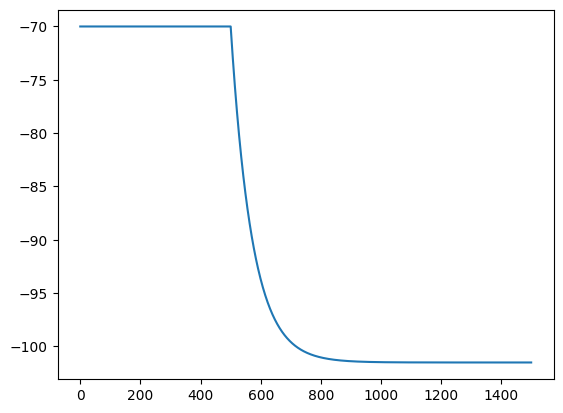

In [6]:
# Predict passive properties
from act.DataProcessor import DataProcessor
from act.cell_model import TrainCell, TargetCell
import matplotlib.pyplot as plt
import numpy as np


# Simulate a negative current injection and get all of the data needed to calculate the passive properties.
# This is a stand in for voltage data provided by the user.
dp = DataProcessor()
(
V,
dt, 
h_tstop, 
I_tstart, 
I_intensity,
cell_area
) = dp.simulate_negative_CI(target_cell, "glbar_leak")

plt.plot(V)

dp = DataProcessor()
props = dp.calculate_passive_properties(V, dt,h_tstop,I_tstart,I_intensity,cell_area,"glbar_leak")

print(props)

In [7]:
from act.cell_model import TrainCell

# Init the cell
train_cell = TrainCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

channel_ranges = [
    (0.0001, 0.0006),  
    (0.01, 0.056),
    (0.01, 0.06),
    (0.00066667, 0.0033),
    (props['g_bar_leak'],props['g_bar_leak']) # We know this conductance
]
channel_samples = [3, 3, 2, 3, 1]
#current_intensities = [0.1, 0.2, 0.3] # same as target_cell. comment out if wanting one control spot
conductance_groups, current_settings = dp.generate_I_g_combinations(channel_ranges, channel_samples, current_intensities)

In [8]:
print(len(conductance_groups))
print(conductance_groups[0])
print(conductance_groups[71])

162
(0.0001, 0.01, 0.01, 0.00066667, 3.500002954275104e-05)
(0.00034999999999999994, 0.01, 0.06, 0.0033, 3.500002954275104e-05)


In [9]:
# Simulate voltage traces
simulator = Simulator()

for i in range(len(conductance_groups)):
        # Set parameters from the grid
        train_cell.set_g(["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"], conductance_groups[i])
        simulator.submit_job(
            train_cell, 
            SimulationParameters(
                sim_name = "train1",
                sim_idx = i,
                h_v_init = -70, # (mV)
                h_tstop = 300,  # (ms)
                h_dt = 0.01, # (ms)
                h_celsius = 37, # (deg C)
                CI = {
                    "type": "constant",
                    "amp": current_settings[i],
                    "dur": 290,
                    "delay": 10
                }
            )
        )

In [10]:
# Run
simulator.run(mod_folder)

from act.DataProcessor import DataProcessor
dp = DataProcessor()
dp.combine_data("./model/train1")

Total number of jobs: 162
Total number of proccessors: 192
MECHANISMS already loaded.


In [ ]:
# MatchFilter will go over saved data and create a dataset of the traces that match,
# deleting others

## 3. Train the model

In [11]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset_train = np.load("./model/train1/combined_out.npy")

dp = DataProcessor()
g_train = dp.clean_g_bars(dataset_train)
V_train = dataset_train[:,:,0]
I_train = dataset_train[:,:,1]

# need in documentation list_of_features
# ["i_mean_stdev", "v_spike_stats", "v_mean_potential", "v_amplitude_frequency", "v_arima_coefs"]
features_train, columns_train = dp.extract_features(V=V_train,I=I_train,inj_dur=290,inj_start=10)

print(f"columns_train: {columns_train}")
print(features_train.shape)

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


  0%|          | 0/162 [00:00<?, ?it/s]/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

columns_train: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
(162, 19)


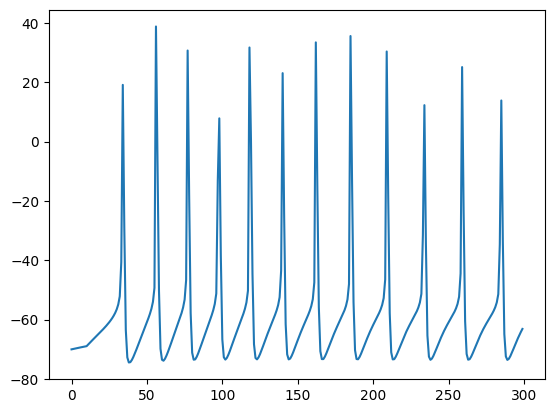

In [12]:
import matplotlib.pyplot as plt
#print(V_train[20])
plt.plot(V_train[-1])
plt.show()

In [13]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset_target = np.load("./model/target1/combined_out.npy")

dp = DataProcessor()
g_target = dp.clean_g_bars(dataset_target)
V_target = dataset_target[:,:,0]
I_target = dataset_target[:,:,1]

features_target, columns_target = dp.extract_features(V=V_target,I=I_target,inj_dur=290,inj_start=10)

print(f"columns_tar: {columns_target}")
print(features_target.shape)

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


  0%|          | 0/3 [00:00<?, ?it/s]/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

columns_tar: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
(3, 19)


In [14]:
# Fitting Random Forest
from act.optimizer import RandomForestOptimizer

X_train = features_train
Y_train = g_train

print(X_train.shape)
print(Y_train.shape)

rf = RandomForestOptimizer()
rf.fit(X_train, Y_train)

(162, 19)
(162, 5)


In [15]:
# Evaluate the model's accuracy
from act.Metrics import Metrics

metrics = Metrics()

metrics.evaluate_random_forest(rf.model, X_train, Y_train)

Evaluating random forest


MAE: 0.002633 (0.000607)


In [16]:
X_test = features_target
prediction = rf.predict(X_test)

print(prediction.shape)
print(prediction)

(3, 5)
[[1.19000000e-04 2.79400000e-02 1.34000000e-02 2.59690089e-03
  3.50000295e-05]
 [3.48250000e-04 2.83770000e-02 2.23500000e-02 2.15186812e-03
  3.50000295e-05]
 [4.29750000e-04 2.14770000e-02 5.99500000e-02 3.02745034e-03
  3.50000295e-05]]


Now with multiple conductance values predicted (one for each current injection intensity). We need a method for selecting the best one. 

Solution: simulate a cell on each conductance set, find the FI curve of each conductance set, get the min mae -> final prediction

In [1]:
import numpy as np
amps = [0.1, 0.2, 0.3]
prediction = np.array([[1.19000000e-04, 2.79400000e-02, 1.34000000e-02, 2.59690089e-03, 3.50000295e-05],
                        [3.48250000e-04, 2.83770000e-02, 2.23500000e-02, 2.15186812e-03, 3.50000295e-05],
                        [4.29750000e-04, 2.14770000e-02, 5.99500000e-02, 3.02745034e-03, 3.50000295e-05]])

In [3]:
from act.cell_model import TargetCell, TrainCell
from act.simulator import Simulator
from act.act_types import SimulationParameters
import numpy as np
# Simulate the conductance values
hoc_file = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc"
mod_folder = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles"

print(prediction)

# The conductance list is set for the train cell, we need a separate cell
test_cell = TrainCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

simulator = Simulator()
for i in range(len(prediction)):
    for j in range(len(amps)):
        # Set parameters from the grid
        test_cell.set_g(["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"], prediction[i])
        simulator.submit_job(
            test_cell, 
            SimulationParameters(
                sim_name = "test"+str(i),
                sim_idx = i * len(prediction) + j,
                h_v_init = -70, # (mV)
                h_tstop = 300,  # (ms)
                h_dt = 0.01, # (ms)
                h_celsius = 37, # (deg C)
                CI = {
                    "type": "constant",
                    "amp": amps[j],
                    "dur": 290,
                    "delay": 10
                }
            )
        )


[[1.19000000e-04 2.79400000e-02 1.34000000e-02 2.59690089e-03
  3.50000295e-05]
 [3.48250000e-04 2.83770000e-02 2.23500000e-02 2.15186812e-03
  3.50000295e-05]
 [4.29750000e-04 2.14770000e-02 5.99500000e-02 3.02745034e-03
  3.50000295e-05]]


In [6]:
# Run
simulator.run(mod_folder)

from act.DataProcessor import DataProcessor
dp = DataProcessor()
for i in range(len(prediction)):
    dp.combine_data("./model/test"+ str(i))

Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.


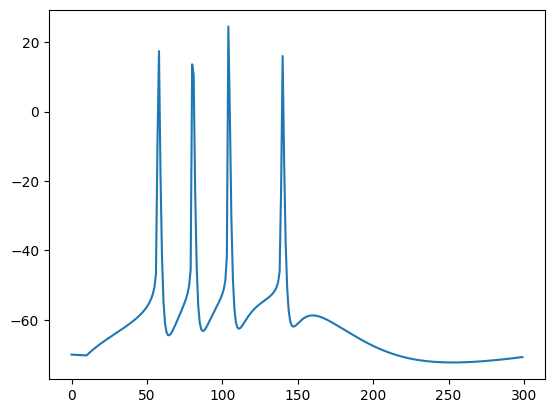

In [9]:
import matplotlib.pyplot as plt
#print(V_train[20])
dataset = np.load("./model/test1/combined_out.npy")
V_test = dataset[:,:,0]
plt.plot(V_test[0])
plt.show()

In [10]:
# Calculate FI values
def get_fi_curve(V_test, amps, ignore_negative=True, inj_dur=1000):
    """
    Returns the spike counts per amp.
    inj_dur is the duration of the current injection
    """

    (   num_spikes,
        interspike_times,
        first_n_spikes, 
        avg_spike_min,
        avg_spike_max
    ) = dp.extract_spike_features(V_test)

    if ignore_negative:
        non_neg_idx = [i for i, amp in enumerate(amps) if amp >= 0]
        amps = [amp for i, amp in enumerate(amps) if amp >= 0]
        num_spikes = num_spikes[non_neg_idx]

    frequencies =  num_spikes / (inj_dur / 1000)  # Convert to Hz: spikes / time (sec)

    return frequencies

In [11]:
from act.DataProcessor import DataProcessor
dp = DataProcessor()

amps = [0.1, 0.2, 0.3]
ignore_negative = True
inj_dur = 290

FI_data = []
for i in range(len(prediction)):
    dataset = np.load("./model/test" + str(i) + "/combined_out.npy")
    V_test = dataset[:,:,0]

    #Get FI curve info
    frequencies = get_fi_curve(V_test, amps, inj_dur=290)

    print(frequencies)

    FI_data.append(frequencies.flatten())

list_of_freq = np.array(FI_data)
print(list_of_freq)

[[0.        ]
 [3.44827586]
 [6.89655172]]
[[13.79310345]
 [17.24137931]
 [20.68965517]]
[[ 6.89655172]
 [10.34482759]
 [13.79310345]]
[[ 0.          3.44827586  6.89655172]
 [13.79310345 17.24137931 20.68965517]
 [ 6.89655172 10.34482759 13.79310345]]


In [13]:
import numpy as np

dataset = np.load("./model/target1/combined_out.npy")

V_target = dataset[:,:,0]

print(V_target.shape)

target_frequencies = get_fi_curve(V_test, amps, inj_dur=290).flatten()

print(list_of_freq)
print(target_frequencies)

from act.Metrics import Metrics
metrics = Metrics()

fi_mae = []
for fi in list_of_freq:
    fi_mae.append(metrics.mae_score(target_frequencies, fi))

selected_prediction = fi_mae.index(min(fi_mae))

print(selected_prediction)
print(fi_mae)

print(prediction[selected_prediction])


(3, 300)
[[ 0.          3.44827586  6.89655172]
 [13.79310345 17.24137931 20.68965517]
 [ 6.89655172 10.34482759 13.79310345]]
[ 6.89655172 10.34482759 13.79310345]
2
[6.8965517241379315, 6.8965517241379315, 0.0]
[4.29750000e-04 2.14770000e-02 5.99500000e-02 3.02745034e-03
 3.50000295e-05]


In [ ]:
import matplotlib.pyplot as plt
#[4.29750000e-04 2.14770000e-02 5.99500000e-02 3.02745034e-03 3.50000295e-05]

plt.plot()